<a href="https://www.kaggle.com/code/syerramilli/lgbm-conformal-reg-part-1-eda-tuning?scriptVersionId=166388935" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

In this notebook, part 1 of a two-part series, we conduct exploratory data analysis followed by the training and fine-tuning of an lightgbm regression model for predicting birth weights. The primary objective of this notebook is to achieve a well-performing model with high cross-validation prediction accuracy, as assessed by the mean absolute error. In part 2, we will use conformal regression to generate prediction intervals. 

**CHANGELOG**:

v1 -> v2:
1. Removed a couple of highly correlated features (Spearman correlations)
2. Added an explicit difference feature between `DOP_MM` and `DLMP_MM`. 

v2 -> v3:
- Using BoTorch API for hyperparameter optimization
- Changes to the hyperparameter space
- Increased budget for hyperparameter optimization


In [1]:
%%capture
!pip install botorch

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
from pathlib import Path

import optuna
import shap

from typing import Dict, Optional, Union

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

## Loading the data and preliminary cleaning

In [3]:
data_path = Path('/kaggle/input/prediction-interval-competition-i-birth-weight')
train = pd.read_csv(data_path / 'train.csv', index_col=['id'])
test = pd.read_csv(data_path / 'test.csv', index_col=['id'])

train.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,...,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,DBWT
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,18.5,0,12,,10,1434,5,99,...,0,0,108,1,1,N,0,F,24,2800
1,1,1,18.3,2,4,1,12,2156,6,39,...,2,1,100,1,1,N,0,M,18,1900
2,1,1,27.3,0,3,2,12,1241,2,31,...,2,2,135,4,1,Y,2,F,27,2960
3,1,1,24.0,0,7,2,4,1649,2,99,...,0,0,111,3,1,N,0,M,29,3657
4,2,1,23.6,0,6,1,3,752,2,31,...,2,0,121,4,1,Y,2,F,37,3742


In [4]:
print(f'Shape of training data (including output): {train.shape}')

Shape of training data (including output): (108082, 37)


The missing values are encoded differently in the dataset - each column has a separate encoding for missing values. See the hidden cell below for the actual encodings. 

In [5]:
missing_codes = {
    'ATTEND': 9, 'BFACIL': 9,
    'BMI': 99.9, 'CIG_0': 99,
    'DLMP_MM': 99,
    'DOB_TT': 9999,
    'FAGECOMB': 99,
    'FEDUC': 9,
    'ILLB_R': 999, 'ILOP_R': 999, 'ILP_R': 999,
    'MBSTATE_REC': 3,
    'MEDUC': 9,
    'M_Ht_In': 99,
    'NO_INFEC': 9, 'NO_MMORB': 9, 'NO_RISKS': 9,
    'PAY': 9, 'PAY_REC': 9,
    'PRE_CARE': 99,
    'PREVIS': 99, 
    'PRIORDEAD': 99, 'PRIORLIVE': 99, 'PRIORTERM': 99,
    'PWgt_R': 999,
    'RDMMETH_REC': 999,
    'RF_CESARN': 99,
    'WTGAIN': 99
}

values = {column:np.nan for column in missing_codes}
# use pd.NA for certain categorical columns
categorical_cols_w_missing = [
    'ATTEND', 'BFACIL', 'LD_INDL', 'PAY, ''PAY_REC',
    'MBSTATE_REC', 'RDMETH_REC'
]

for column in categorical_cols_w_missing:
    if column in values:
        values[column] = pd.NA

We will replace them with `pd.NA` or `np.nan` depending on the type of the column. lightgbm and other boosting models can natively handle missing values, so they might not require preprocessing. 

In [6]:
train = train.replace(to_replace=missing_codes, value=values)
test = test.replace(to_replace=missing_codes, value=values)

## Target variable to predict

The goal of this competion is to predict the birth weight in grams - column `DBWT` in the training data. The distribution semes to be heavy tailed on both sides.

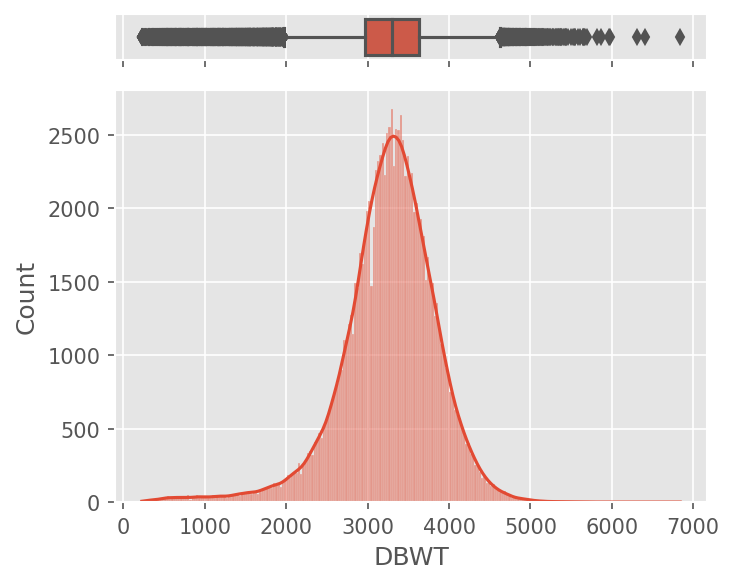

In [7]:
fig, (ax_box, ax_hist) = plt.subplots(
    2, figsize=(5, 4), sharex=True, gridspec_kw={"height_ratios": (.1, .9)}
)

_ = sns.boxplot(data=train, x='DBWT', ax=ax_box)
_ = sns.histplot(data=train, x='DBWT', kde=True, ax=ax_hist)

_ = ax_box.set(yticks=[], xlabel=None)

fig.tight_layout()

## Feature Analysis

A thorough description of the features is available at https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/DVS/natality/UserGuide2018-508.pdf.


### Missing values

After the encoding, most of the features have some missing entries. However, the percentage of missing entries is not high for any of these features. Since lightgbm can natively handle missing entries, we will not clean them here. 

In [8]:
from numbers import Number

def filter_greater_than(s:pd.Series, threshold:Number) -> pd.Series:
    return s[s > threshold]

missing_perc_train = (
    (train.isna().sum() / train.shape[0] * 100)
    .pipe(filter_greater_than, threshold=0)
    .sort_values(ascending=False)
    .round(3)
)

missing_perc_train

FEDUC          13.745
ILP_R          11.977
FAGECOMB       11.633
ILOP_R          9.921
DLMP_MM         4.696
ILLB_R          3.174
WTGAIN          3.041
PREVIS          2.540
BMI             2.270
PWgt_R          2.023
MEDUC           1.333
PAY             0.575
PAY_REC         0.575
M_Ht_In         0.507
CIG_0           0.477
PRIORTERM       0.300
PRIORDEAD       0.224
MBSTATE_REC     0.195
NO_INFEC        0.187
PRIORLIVE       0.158
NO_MMORB        0.055
ATTEND          0.052
RF_CESARN       0.037
BFACIL          0.010
DOB_TT          0.002
dtype: float64

### Mode-dominant features

We now check if there is any feature for which its mode has more than 90% of the observations. It is unlikely that any model can reliably use such features. So, we will drop them

In [9]:
def get_mode_fraction(x:pd.Series) -> float:
    cts = x.value_counts(sort=True, ascending=False)
    return cts.iloc[0] / x.shape[0]

high_mode_per = (
    train.drop('DBWT', axis=1)
    .apply(get_mode_fraction)
    .pipe(filter_greater_than, threshold=0.9)
)

high_mode_per

BFACIL       0.983901
CIG_0        0.912576
NO_INFEC     0.970578
NO_MMORB     0.985844
PRIORDEAD    0.986205
dtype: float64

In [10]:
# drop these columns
train = train.drop(high_mode_per.index.tolist(), axis=1)
print(f'Number of features after dropping: {train.shape[1] - 1}')

Number of features after dropping: 31


### Redundant features 

 1. Both PAY and PAY_REC pertain to the same attribute—mode of payment—though PAY_REC has fewer categories. Consequently, we will exclude PAY from the feature list.
 2. `RF_CESAR` can be derived from `RF_CESARN`

In [11]:
train = train.drop(
    ['PAY', 'RF_CESAR'],
    axis=1
)

### Categorical features

There are quite a few categorical features. Some of them are encoded as integers. Since lightgbm can natively handle categorical features, we will not process them further.

In [12]:
categorical_cols = [
    'ATTEND', 'DMAR', 'LD_INDL', 'PAY_REC',
    'MBSTATE_REC', 'RDMETH_REC', 'RESTATUS',
    'SEX'
]

# convert these columns to type category
# needed for lightgbm to process them correctly
for column in categorical_cols:
    train[column] = train[column].astype("category")

We present boxplots depicting the distribution of the target variable `DBWT` grouped by each category within every categorical feature. There are no discernible differences across the categories for any of the categorical features. 

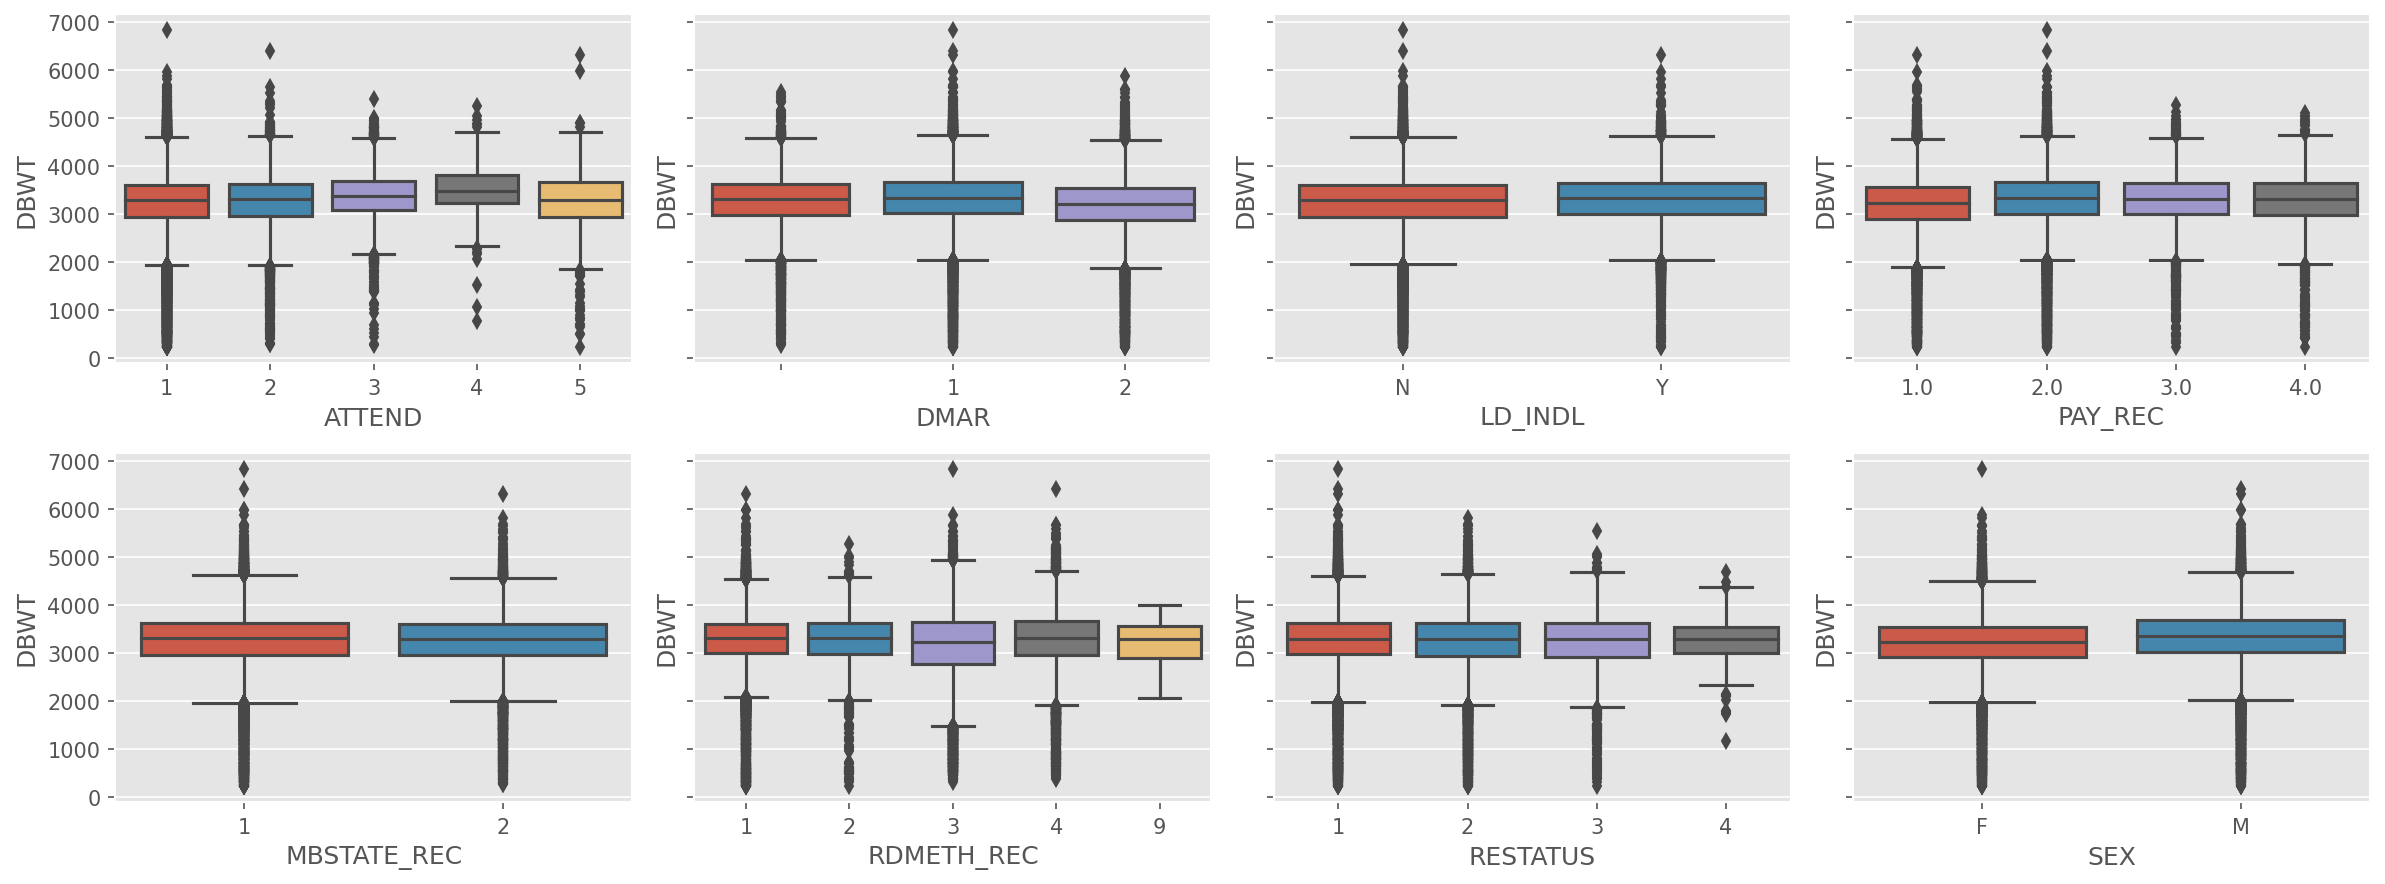

In [13]:
n_rows = 2
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharey=True)

for i in range(n_rows):
    for j in range(n_cols):
        idx = n_cols * i + j
        _ = sns.boxplot(
            train, 
            x= categorical_cols[idx],
            y='DBWT',
            ax=axs[i, j]
        )

fig.tight_layout()

### Correlation analysis - hierarchical clustering

We now compute the Spearman rank correlations between pairs of the features, and drop ones which are highly correlated with each other. Since there are many columns, we will perform hierarchical clustering to cluster the features.

Hierarchical clustering arranges the data (in our case, features) using a dissimilarity (or distance) matrix. In our case, we compute the dissimilarity between two features $x_i$ and $x_j$  as

$$
    \large
    d(x_i,x_j) = 1 - |r(x_i, x_j)|,
$$

where $r(x_i, x_j)$ is the Spearman rank correlation between $x_1$ and $x_2$. The Spearman rank measures the degrees of monotonic dependence between two features. Values closer to +1 or -1 indicate a monotonically increasing or decreasing relationships respectively. So, the dissimilarity between two features will be close to 0 if they are nearly monotonic fuctions of each other. 

In [14]:
# hierarchical clustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# construct correlation matrix
corr_matrix = (
    train.select_dtypes('number')
    .drop('DBWT', axis=1)
    .corr(method='spearman')
)

# hierarchical cluster based on the correlations
dissimilarity = 1 - abs(corr_matrix.values)

After computing the dissimilaity matrix, we then perform hierarchical clustering on the features. We can then visualize the hierarchy of relationships using a dendrogram plot, which displays a tree-like structure, with branches that represent the merging of similar features at different levels of dissimilarity. The leaves of the dendograms are the features.

There are a couple of features that are near monotonic functions of each other

1. `ILOP_R` and `PRIORTERM`
2.  `PWgt_R` and `BMI`

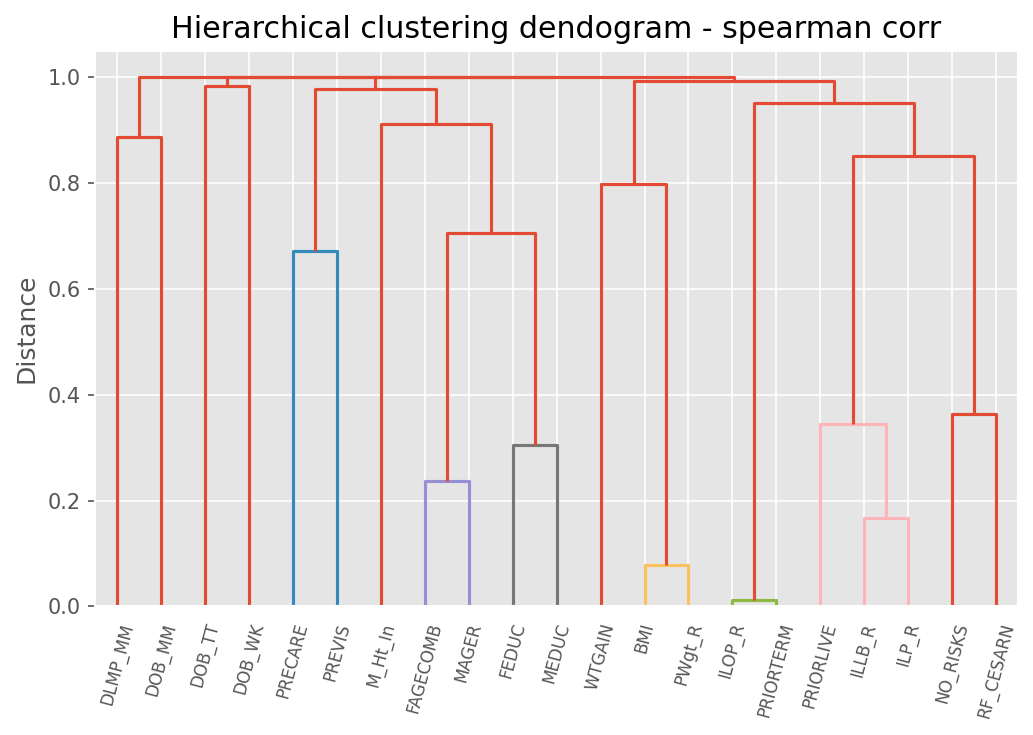

In [15]:
linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

# plot the dendogram
fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax, 
    labels=corr_matrix.columns.tolist(),
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=75, fontsize=8)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram - spearman corr')
fig.tight_layout()

We will drop the second feature in both cases.

In [16]:
train = train.drop(['PRIORTERM', 'BMI'], axis=1)

### Feature engineering

In V1 of the notebook, we found that `DLMP_MM` and `DOB_MM` are among the top 3 important features bases on SHAP effects. We speculated that their difference might be an approximation for the pregnancy term. We will add an explicit feature that captures this relation: `preg_dur_approx`.

In [17]:
train['preg_dur_approx'] = train['DOB_MM'] - train['DLMP_MM']

# negative durations don't make sense. 
# Credit: https://www.kaggle.com/code/paddykb/lgbm-mapie-birth-weight-oh-my
train['preg_dur_approx'] = np.where(
    train['preg_dur_approx'] < 0,
    train['preg_dur_approx'] + 12,
    train['preg_dur_approx']
)

invalid value encountered in divide


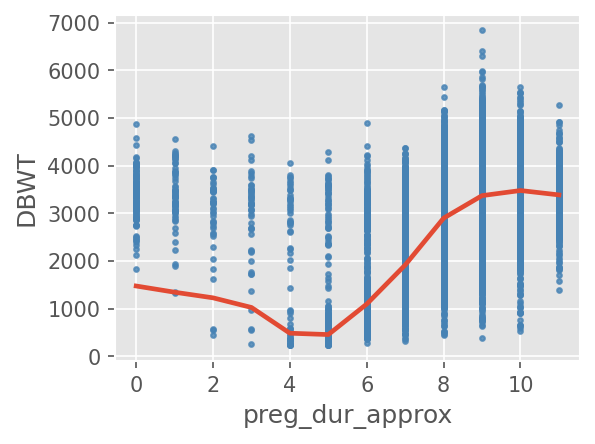

In [18]:
# scatter plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
_ = sns.regplot(
    train, x='preg_dur_approx', 
    y='DBWT', 
    ax=ax,
    lowess=True,
    scatter_kws= {'color':'steelblue', 's':5}
)

## Preparing the data



In [19]:
X = train.drop('DBWT', axis=1)
y = train['DBWT'].values

Conformalized quantile regression (CQR) methods require a calibration set for generating the prediction intervals. We will create a calibration split **prior** to tuning the hyperparameters. This calibration set will be used in the next notebook.

In [20]:
X_train, X_calib, y_train, y_calib = train_test_split(
    X, y, test_size=0.2, random_state=1
)

## Tuning lightgbm hyperparameters

In [21]:
def fit_and_validate_lgbm_model(
    X: pd.DataFrame,
    y: np.array,
    train_index: np.array,
    val_index: np.array,
    params: Optional[Dict] = None,
    n_jobs: int = 4,
):
    X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_train, y_val = y[train_index], y[val_index]

    model = LGBMRegressor(
        objective='quantile',
        alpha=0.5,
        n_jobs=n_jobs,
        subsample_freq=1
    )

    if params is not None:
        model.set_params(**params)

    # train model
    _ = model.fit(X_train, y_train)

    # obtain predictions
    y_val_pred = model.predict(X_val)

    # return metrics
    return mean_absolute_error(y_val, y_val_pred)

In [22]:
import joblib
import warnings

def optuna_objective(trial: optuna.trial.Trial) -> float:
    config = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.75, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 256, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 16, log=True),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1),
        #'colsample_bynode': trial.suggest_float("colsample_bynode", 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 100,log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-8, 100,log=True),
        'subsample': trial.suggest_float("subsample", 0.1, 1),
        #'subsample_freq': trial.suggest_int("subsample_freq", 1, 10, log=True),
    }
    
    n_splits = 4
    cv = KFold(n_splits=n_splits, random_state=1, shuffle=True)
    cv_mae = [None] * n_splits
    for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
        cv_mae[i] = fit_and_validate_lgbm_model(X_train, y_train, train_index, test_index, config)
        
    # saving the individual fold holdout metrics 
    # uncomment this line if you don't want this
    trial.set_user_attr('split_mae', cv_mae)
        
    return np.mean(cv_mae)


with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=optuna.exceptions.ExperimentalWarning)
    warnings.simplefilter(action="ignore", category=FutureWarning)
    
    study = optuna.create_study(
        directions=['minimize'], 
        #sampler=optuna.samplers.TPESampler(n_startup_trials=10, seed=0),
        sampler=optuna.integration.botorch.BoTorchSampler(n_startup_trials=10, seed=0),
        study_name='lgbm'
    )

    # run optuna for a maxmimum of 100 trials and 2hr wall clock time
    study.optimize(optuna_objective, n_trials=100, timeout=7200) 

# save the runs
_ = joblib.dump(study, 'lightgbm_hyperopt_birthweight.pkl')


[I 2024-03-11 01:59:49,205] A new study created in memory with name: lgbm
[I 2024-03-11 01:59:56,641] Trial 0 finished with value: 365.0328571785014 and parameters: {'n_estimators': 322, 'learning_rate': 0.11381860101766887, 'num_leaves': 63, 'max_depth': 9, 'colsample_bytree': 0.4812893194050143, 'reg_alpha': 0.028770084050677908, 'reg_lambda': 0.00023761404778025518, 'min_split_gain': 8.274276086161453, 'subsample': 0.9672964844509263}. Best is trial 0 with value: 365.0328571785014.
[I 2024-03-11 02:00:11,280] Trial 1 finished with value: 361.12938110237917 and parameters: {'n_estimators': 183, 'learning_rate': 0.18891132244670047, 'num_leaves': 49, 'max_depth': 9, 'colsample_bytree': 0.933036974463395, 'reg_alpha': 5.132873745854718e-08, 'reg_lambda': 7.435205853060173e-08, 'min_split_gain': 1.5928833561691773e-08, 'subsample': 0.8493578609931441}. Best is trial 1 with value: 361.12938110237917.
[I 2024-03-11 02:02:44,289] Trial 2 finished with value: 499.15172683031267 and paramete

In [23]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV MAE')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

In [24]:
results = study.trials_dataframe(attrs=('number','value', 'duration', 'params'))
results = results.rename(columns={'value':'MAE'})
results['duration'] = results['duration']/np.timedelta64(1, 's')
results = results.sort_values(by='MAE',ascending=True)
results.to_csv('cv_mae_history.csv',index=False)

The best hyperparameters found so far are as follows:

In [25]:
study.best_params

{'n_estimators': 786,
 'learning_rate': 0.030230382135759997,
 'num_leaves': 38,
 'max_depth': 7,
 'colsample_bytree': 0.6723430646067382,
 'reg_alpha': 6.654071936233027e-06,
 'reg_lambda': 0.00024010123501673372,
 'min_split_gain': 7.742586691347851e-07,
 'subsample': 0.6951020199312409}

## Final LGBM model

In [26]:
model = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    n_jobs=4, 
    subsample_freq=1,
    **study.best_params
).fit(X_train, y_train)

_ = model.booster_.save_model(
    filename='lgbm_birthweights.txt',importance_type='gain'
)

## Feature importances through SHAP

The default feature importances computed by lightgbm (or any tree based model) can be misleading. Here, we will use SHAP measures to check the importance of each feature. SHAP values represent the impact of each feature on the model's output.

In [27]:
%%time
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train.dropna())

CPU times: user 12min 51s, sys: 9.5 ms, total: 12min 51s
Wall time: 3min 19s


In the SHAP summary plot, we plot a horizontal bar plot of the absolute SHAP value for each feature averaged across the observations. Features with longer bars have a higher influence on the model's output.

After selecting hyperparameters through a preliminary hyperparameter optimization run, we find the following:

1. `preg_dur_approx` is now the most important feature. It clearly explains the the effects of `DLMP_MM` and `DOB_MM`, 

2. The next important features are `WTGAIN` (the increase in the mother's weight during pregnancy) and`PWgt_R` (mother's weight before pregnancy). 

**NOTE**: The observations here can change with a model selected from a more exhaustive hyperparameter optimization run.


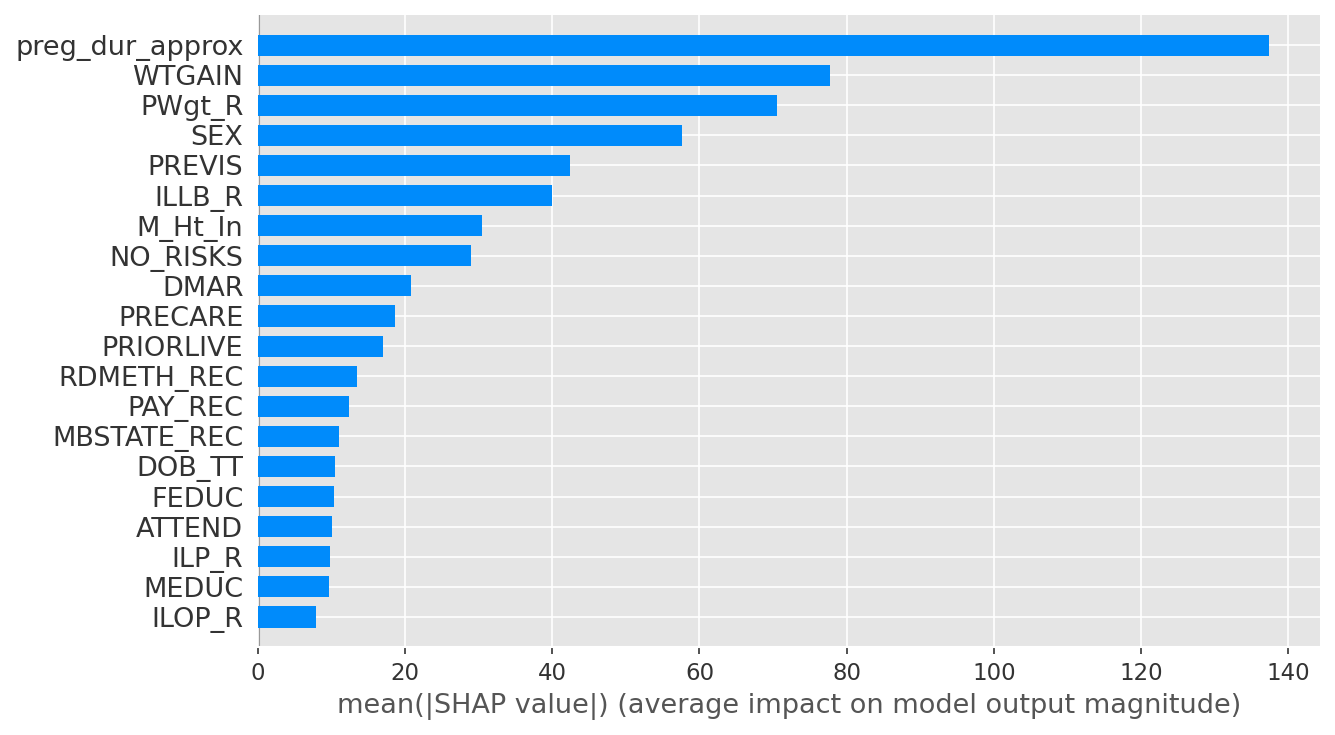

In [28]:
# Average of SHAP value magnitudes across the dataset
shap.summary_plot(
    shap_values, X_train, plot_type="bar",
    plot_size = (9,5)
)

We proceed to display SHAP dependence plots below for the top 3 features. These plots provide a succinct visual representation of the relationship between a specific feature and the SHAP values, offering insights into the impact of each feature on the model predictions.

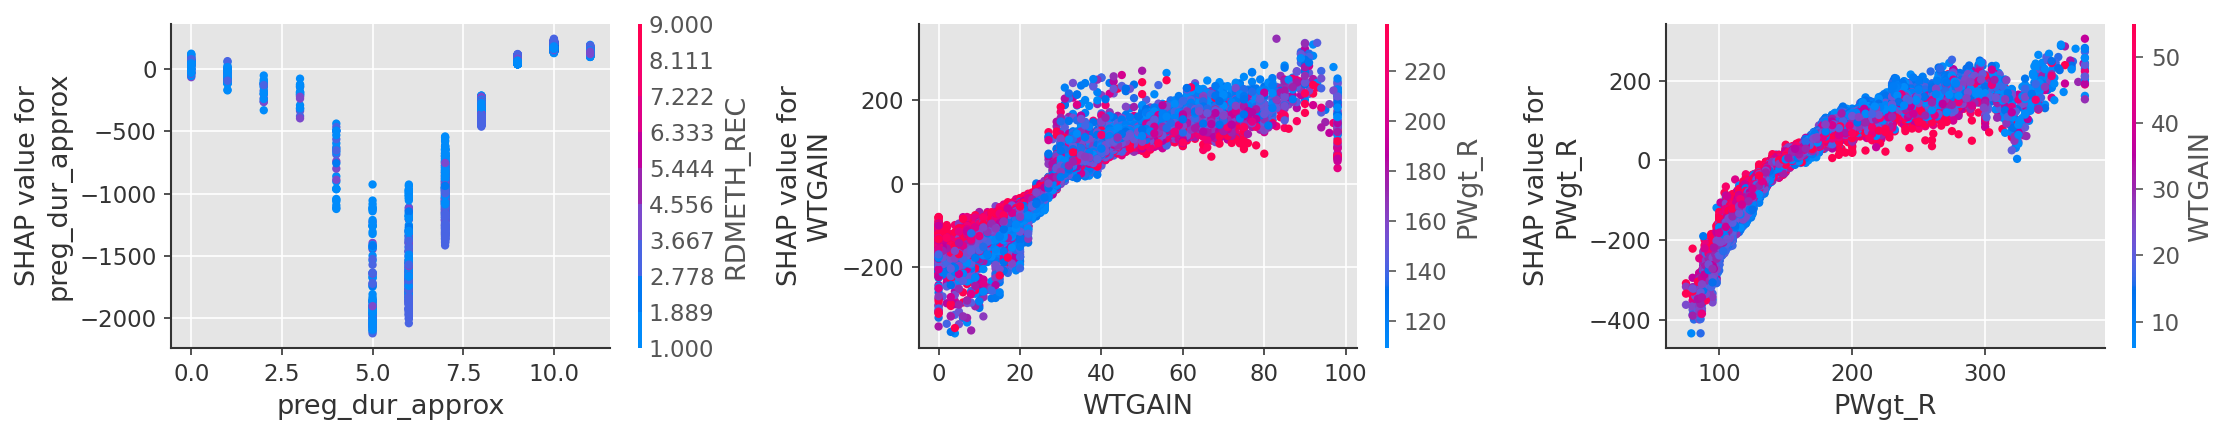

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(5 * 3, 3)) 
# SHAP dependence plots
for i, col in enumerate(['preg_dur_approx', 'WTGAIN', 'PWgt_R']):
    shap.dependence_plot(col, shap_values, X_train.dropna(), ax=axs[i], show=False)
    
fig.tight_layout()